In [10]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy 

In [2]:
# Function to load, process, and return data from a CSV file
def load_and_process_csv(file_path):
    data = np.loadtxt(file_path, delimiter=',')
    first_entry = data[0]
    print(f"First entry from {file_path}: {first_entry}")
    data = np.delete(data, 0, axis=0)
    if data.shape[1] < 2:
        raise ValueError(f"Data in {file_path} must have at least two columns for 2D plotting")
    return data

First entry from HMC_data/HMC_samples_15D_10000.csv: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
First entry from HMC_data/HMC_samples_15D_50000.csv: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
First entry from HMC_data/HMC_samples_15D_100000.csv: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


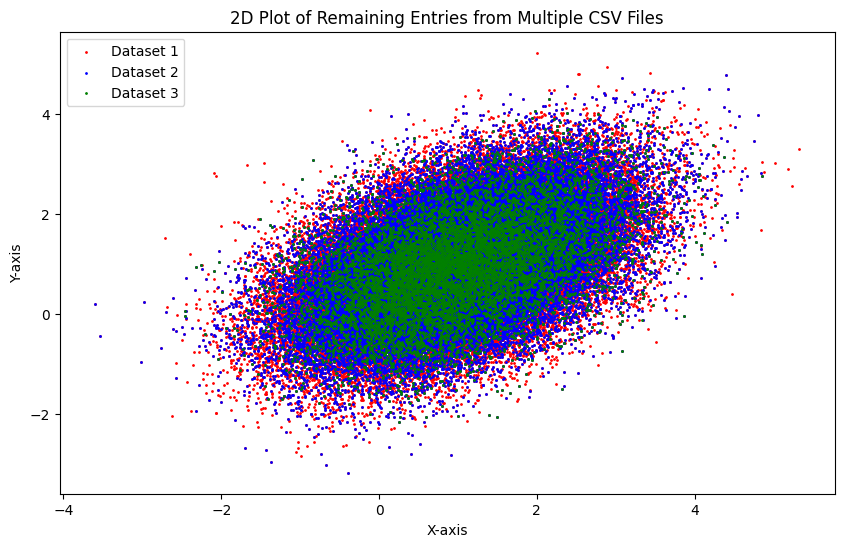

In [15]:
# Paths to the CSV files
csv_file_paths = ['HMC_data/HMC_samples_15D_10000.csv', 'HMC_data/HMC_samples_15D_50000.csv', 'HMC_data/HMC_samples_15D_100000.csv']  # Replace with your actual file paths

# Load and process each CSV file
datasets = [load_and_process_csv(file_path) for file_path in csv_file_paths]

# Define colors for each dataset
colors = ['red', 'blue', 'green']

# Plot the data
plt.figure(figsize=(10, 6))
for i, data in enumerate(datasets[::-1]):
    plt.scatter(data[:, 0], data[:, 1], color=colors[i], label=f'Dataset {i+1}',s=1)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Plot of Remaining Entries from Multiple CSV Files')
plt.legend()
plt.show()

In [16]:
print(datasets[0][1])
print(datasets[1][1])
print(datasets[2][1])

[-0.07752731  0.03508421  0.21156786 -0.04891608 -0.16790105 -1.0131509
 -1.3910878  -0.5802959  -0.09144422 -0.7227541  -0.5895866  -0.03871454
 -1.0859724  -0.00473109  1.2823509 ]
[-0.15024622 -0.2556968   0.11608994  0.4075761   0.25448468 -0.12400904
 -0.22114402  0.19037114  0.14922579  0.520802   -0.02036663  0.23758863
  0.29052922  0.05048445 -0.34289613]
[-0.05268955  0.18945558 -0.6845284  -0.02300512 -0.6226631  -0.59568065
  0.35724422 -0.35521278  0.90982985  0.3542251  -0.09050998  0.5322387
 -0.4860009   1.1594635   0.49157482]


In [17]:
print(emcee.autocorr.integrated_time(datasets[0]))
print(emcee.autocorr.integrated_time(datasets[1]))
print(emcee.autocorr.integrated_time(datasets[2]))

[84.05993049]
[67.12955782]
[66.34664174]


In [11]:
class MetropolisHastings:
    def __init__(self, target_distr, initial_state=None, seed=None):
        """
        Initialize the Metropolis-Hastings sampler.
        
        Parameters:
        - target_distr: function
            The target distribution from which we want to sample.
        - initial_state: array-like, optional
            The initial state of the Markov chain. Default is a zero vector.
        - seed: int, optional
            Random seed for reproducibility. Default is None.
        """
        self.target_distr = target_distr
        self.dim = len(initial_state) if initial_state is not None else 1
        self.initial_state = np.array(initial_state) if initial_state is not None else np.zeros(self.dim)
        self.seed = seed
        self.samples = []
        self.acceptance_rate = 0.0
        self.mean = None
        self.covariance = None
        self.time = 0.0
        
        if seed is not None:
            np.random.seed(seed)
    
    def sample(self, n_samples):
        """
        Generate samples using the Metropolis-Hastings algorithm.
        
        Parameters:
        - n_samples: int
            The number of samples to generate.
        
        Returns:
        - samples: np.array
            Array of generated samples.
        """
        start_time = time.time()
        
        proposal_distr = scipy.stats.multivariate_normal
        # Random covariance matrix for the proposal distribution
        A = np.random.rand(self.dim, self.dim)
        cov = np.dot(A, A.T)
        
        x_t = self.initial_state
        samples = []
        accept_count = 0
        
        while len(samples) < n_samples:
            x_prime = proposal_distr.rvs(mean=x_t, cov=cov)
            acceptance_ratio = (self.target_distr(x_prime) * proposal_distr.pdf(x_t, mean=x_prime, cov=cov)) / \
                               (self.target_distr(x_t) * proposal_distr.pdf(x_prime, mean=x_t, cov=cov))
            
            acceptance_ratio = min(1, acceptance_ratio)
            if np.random.uniform(0, 1) < acceptance_ratio:
                x_t = x_prime
                samples.append(x_t)
                accept_count += 1
            else:
                samples.append(x_t)
        
        self.samples = np.array(samples)
        self.acceptance_rate = accept_count / n_samples
        self.mean = np.mean(self.samples, axis=0)
        self.covariance = np.cov(self.samples.T)
        
        self.time = time.time() - start_time
        
        return self.samples

In [17]:
# Define the target distribution: a 2D Gaussian
def target_distribution(x):
    mean = np.array([0, 0])
    cov = np.array([[1, 0], [0, 1]])
    return scipy.stats.multivariate_normal.pdf(x, mean=mean, cov=cov)

In [30]:
samples = MetropolisHastings(target_distribution, initial_state=[0, 0], seed=42).sample(20000)

In [31]:
emcee.autocorr.integrated_time(samples)

array([43.88798022])